In [1]:
import numpy as np
import indigo as ig
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
PATH = "../data/Adrenergic_dataset.csv"
FOLDS = 5
SEED = 42
TARGET_VAL = "logP" # or "AdrA1B_PCHEMBL_VALUE"
columns = ["Structure", "ID", "logP", "AdrA1B_PCHEMBL_VALUE"]

In [3]:
df = pd.read_csv(PATH)
df.head()

,Structure,ID,logP,Vx,MW,NegativeCharge,PositiveCharge,Flex,AromaticRings,OverallCharge,...,q485,frg-8,frg-26,frg-54,Nn,AdrA1A_PCHEMBL_VALUE,AdrA1B_PCHEMBL_VALUE,AdrA1D_PCHEMBL_VALUE,AdrA2A_PCHEMBL_VALUE,AdrA2C_PCHEMBL_VALUE
0,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,CHEMBL411,4.871,224.4,268.4,0,0,0.1905,2,0,...,4,2,0,0,0,NaN,NaN,NaN,NaN,5.66
1,CSc1ccc2Sc3ccccc3N(CCC4CCCCN4C)c2c1,CHEMBL479,5.900,290.2,370.6,0,2,0.1429,2,2,...,18,0,0,0,2,NaN,NaN,NaN,NaN,7.60
2,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1,CHEMBL2205811,3.040,225.5,309.4,0,1,0.1379,1,1,...,4,0,0,0,1,NaN,NaN,NaN,NaN,6.25
3,COc1cc(CN[C@H]2C3C4CC5C6C4CC3C6C25)cc(OC)c1OC,CHEMBL2432051,3.380,256.3,341.4,0,1,0.2000,1,1,...,8,0,0,0,1,NaN,NaN,NaN,NaN,5.64
4,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1OC,CHEMBL2205813,2.899,245.4,339.4,0,1,0.1613,1,1,...,6,0,0,0,1,NaN,NaN,NaN,NaN,5.36


Text(0.5, 1.0, 'logP distribution')

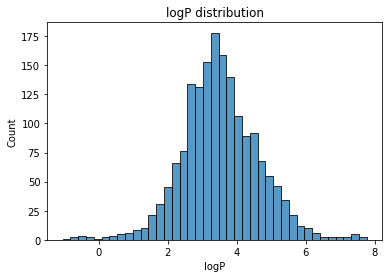

In [4]:
sns.histplot(df["logP"]).set_title(f"logP distribution")

Text(0.5, 1.0, 'AdrA1B_PCHEMBL_VALUE distribution')

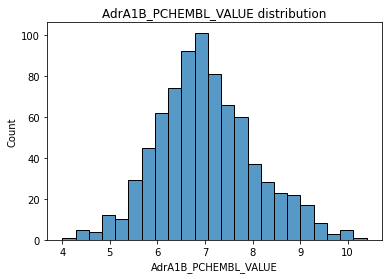

In [5]:
sns.histplot(df["AdrA1B_PCHEMBL_VALUE"]).set_title("AdrA1B_PCHEMBL_VALUE distribution")

In [6]:
dataset = df[columns]
#mean = dataset["AdrA1B_PCHEMBL_VALUE"].median()
#dataset.fillna({"AdrA1B_PCHEMBL_VALUE": mean}, inplace=True)
#print(len(dataset))
dataset.dropna(subset=["AdrA1B_PCHEMBL_VALUE"], inplace=True)
#print(len(dataset))

In [14]:
indigo = ig.Indigo()

def nat_fps():
    indigo.setOption("ignore-stereochemistry-errors", True)
    indigo.setOption("ignore-bad-valence", True)
    indigo.setOption("similarity-type", "ecfp6")
    indigo.setOption("fp-sim-qwords", 8)
    indigo.setOption("fp-ord-qwords", 25)
    indigo.setOption("fp-any-qwords", 15)
    indigo.setOption("fp-tau-qwords", 25)
    indigo.setOption("fp-ext-enabled", True)
    fingerprints = []
    max_val = -np.Inf

    for struct in dataset["Structure"]:
        mol = indigo.loadMolecule(struct)
        mol.aromatize()
        fingerprint = mol.fingerprint("full").toBuffer()
        buffered = np.frombuffer(fingerprint, dtype=np.uint8)
        fingerprints.append(buffered)
        max_val = max(max_val, *buffered)

    fingerprints = np.array(fingerprints, dtype=np.float32) / max_val
    print(fingerprints)
    return fingerprints

def sim_fps():
    fingerprints = []

    max_val = -np.Inf

    for struct in dataset["Structure"]:
        mol = indigo.loadMolecule(struct)
        fingerprint = mol.fingerprint("sim").toBuffer()
        buffered = np.frombuffer(fingerprint, dtype=np.uint8)
        fingerprints.append(buffered)
        max_val = max(max_val, *buffered)

    fingerprints = np.array(fingerprints, dtype=np.float32) / max_val
    print(fingerprints)
    return fingerprints

fingerprints = nat_fps()
dataset["fp"] = [fp for fp in fingerprints]
dataset.head()

[[0.02745098 0.         0.         ... 0.1882353  0.00784314 0.12156863]
 [0.15294118 0.         0.         ... 0.1882353  0.01176471 0.07450981]
 [0.05882353 0.         0.         ... 0.54901963 0.03921569 0.01960784]
 ...
 [0.12156863 0.04705882 0.         ... 0.7372549  0.34117648 0.40392157]
 [0.24705882 0.         0.         ... 0.6117647  0.2627451  0.43529412]
 [0.24705882 0.         0.         ... 0.6117647  0.2627451  0.43529412]]


,Structure,ID,logP,AdrA1B_PCHEMBL_VALUE,fp
15,C(COc1ccccc1)NC[C@H]2COCC(O2)(c3ccccc3)c4ccccc4,CHEMBL2312538,3.975,6.77,"[0.02745098, 0.0, 0.0, 0.0, 0.08627451, 0.1254..."
20,COc1ccccc1OCCNCCOc2ccccc2OCc3ccccc3,CHEMBL1254915,3.747,7.70,"[0.15294118, 0.0, 0.0, 0.0, 0.07058824, 0.0196..."
23,Clc1ccccc1C2CCN(CCN3C(=O)CC4(CCCC4)CC3=O)CC2,CHEMBL56292,3.381,8.11,"[0.05882353, 0.0, 0.0, 0.6431373, 0.03137255, ..."
26,O[C@@H]1[C@@H](CNCCOc2ccccc2)CCC1(c3ccccc3)c4c...,CHEMBL1962872,4.741,6.54,"[0.02745098, 0.0, 0.0, 0.0, 0.039215688, 0.156..."
36,Clc1ccc(Cl)c(c1)N2CCN(CCN3C=CC4(CCCC4)CC3=O)CC2,CHEMBL292366,3.584,7.80,"[0.12156863, 0.015686275, 0.0, 0.6431373, 0.17..."


In [15]:
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR


def oof(reg, bundle):
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    X_train, X_test, y_train, y_test = bundle
    train_errors = []
    oof_errors = []
    errors = []
    for i, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
        X_tr = X_train[train_idx]
        y_tr = y_train[train_idx]
        X_te = X_train[test_idx]

        reg = reg.fit(X_tr, y_tr)
        oof_pred = reg.predict(X_te)
        train_pred = reg.predict(X_tr)
        test_pred = reg.predict(X_test)
        oof_score = r2_score(y_train[test_idx], oof_pred)
        train_score = r2_score(y_tr, train_pred)
        #print("out of fold: ", r2_score(y_train[test_idx], oof_pred), "train: ", r2_score(y_tr, train_pred))
        train_errors.append(train_score)
        oof_errors.append(oof_score)
        errors.append(r2_score(y_test, test_pred))

    print("MEAN TRAIN: ", np.mean(train_errors))
    print("MEAN VALIDATION: ", np.mean(oof_errors))
    
    return errors, test_pred

In [24]:
bundle = train_test_split(fingerprints, dataset["AdrA1B_PCHEMBL_VALUE"].values, shuffle=True, random_state=SEED, test_size = 0.25)
y_test = bundle[3]
#model = SVR()
model = RandomForestRegressor(n_estimators=200, max_features=0.5, max_depth=12, min_samples_leaf=2)
errors, y_pred = oof(model, bundle)
print("MEAN TEST", np.mean(errors))

MEAN TRAIN:  0.911759760483352
MEAN VALIDATION:  0.5325629672358693
MEAN TEST 0.5741605536234623


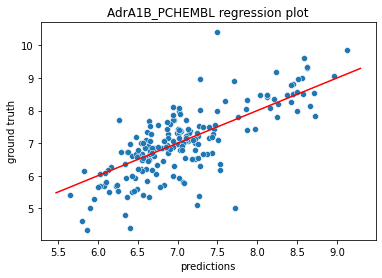

In [17]:
output = pd.DataFrame({"predictions":y_pred, "ground truth": y_test})

regplot = sns.scatterplot(data=output, x=output["predictions"], y=output["ground truth"])
regplot.set_title(f"AdrA1B_PCHEMBL regression plot")
x0, x1 = regplot.get_xlim()
y0, y1 = regplot.get_ylim()

lims = [max(x0, y0), min(x1, y1)]
regplot.plot(lims, lims, '-r')

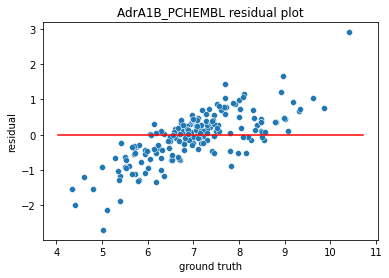

In [18]:
output = pd.DataFrame({"ground truth":y_test, "residual": (y_test - y_pred)})

regplot = sns.scatterplot(data=output, x=output["ground truth"], y=output["residual"])
regplot.set_title(f"AdrA1B_PCHEMBL residual plot")
x0, x1 = regplot.get_xlim()
y0, y1 = regplot.get_ylim()

lims = [max(0, y0), min(x1, 0)]
regplot.plot([x0, x1], [0, 0], '-r')

In [19]:
bundle = train_test_split(fingerprints, dataset["logP"].values, shuffle=True, random_state=SEED, test_size = 0.25)
y_test = bundle[3]
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

model = SVR()
#model = RandomForestRegressor(n_estimators=100, max_features=0.8, max_depth=10, min_samples_leaf=2)
errors, y_pred = oof(model, bundle)
print("MEAN TEST", np.mean(errors))


MEAN TRAIN:  0.8750746701202742
MEAN VALIDATION:  0.7283505050887451
MEAN TEST 0.7631881541647046


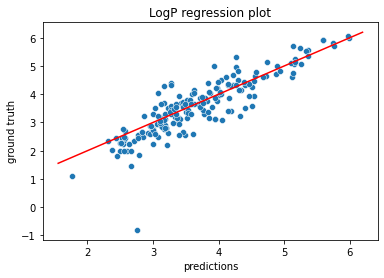

In [20]:
output = pd.DataFrame({"predictions": y_pred, "ground truth": y_test})

regplot = sns.scatterplot(data=output, x=output["predictions"], y=output["ground truth"])
regplot.set_title(f"LogP regression plot")
x0, x1 = regplot.get_xlim()
y0, y1 = regplot.get_ylim()

lims = [max(x0, y0), min(x1, y1)]
regplot.plot(lims, lims, '-r')

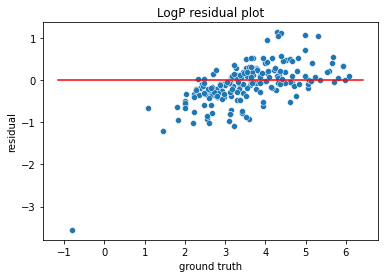

In [21]:
output = pd.DataFrame({"ground truth": y_test, "residual": (y_test - y_pred)})

regplot = sns.scatterplot(data=output, x=output["ground truth"], y=output["residual"])
regplot.set_title(f"LogP residual plot")
x0, x1 = regplot.get_xlim()
y0, y1 = regplot.get_ylim()

regplot.plot([x0, x1], [0, 0], '-r')